# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. 

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## 1. Откройте и изучите файл

Наши данные хранятся в файле "/datasets/users_behavior.csv". Прочитаем данный файл и посмотрим на наши данные.

In [1]:
import pandas as pd 

df = pd.read_csv('../datasets/users_behavior.csv')
df.head(15)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


У нас имеется 5 столбцов:

* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Первые 4 столбца отлично подходят под признаки, а последний столбец "is_ultra" является для нас целевым с двумя категориями - 1 и 0. Данные категории определяют последний тариф для пользователя. 


Произведём разделение наших данных по следующей схеме:

* X_train - признаки для обучения
* y_train - цели для обучения
* X_val - валидационная выборка признаков
* y_val - валидационная выборка целей
* X_test - тестовая выборка признаков
* y_test- тестовая выборка целей

## 2. Разбейте данные на выборки

Для начала, разделим наши признаки и цели из общей таблицы. Для этого сохраним их в переменных *X (features)* и *y (targets)*

In [3]:
y = df['is_ultra']
X = df.drop('is_ultra', axis = 1)

Разделим нашу выборку из соотношения 3:1:1. У нас имеется 3214 записей. Сперва, разделим на обучающие и тестовые данные (60 / 40), а после разделим тестовую выборку на 2 части. Итого у нас получится:

* 60% под обучение
* 20% под валидацию
* 20% под тест

Разделение будем производить при помощи функции *train_test_split* библиотеки *sklearn*.


In [4]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4, random_state = 322)
X_test,X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 322) 

Проверим, что размерности совпадают с изначально запланированным распределением. 

In [5]:
print(f"Train shape {X_train.shape}\nVal shape {X_val.shape}\nTest shape {X_test.shape}")

Train shape (1928, 4)
Val shape (643, 4)
Test shape (643, 4)


## 3. Исследуйте модели

Перед нами стоит задача классификации, поэтому используем следующие модели для исследования:

* RandomForestClassifier
* DecisionTreeClassifier 
* LogisticRegression 

Для нас ключевой метрикой является *accuracy*. В связи с этим, мы будем сразу просчитывать процент точности, используя метод *model.score(x,y)*, где x-признаки, а y-цели. 


### RandomForestClassifier

Сначала из библиотеки *sklearn.ensemble* импортируем требуемый нам классификатор. 

In [6]:
from sklearn.ensemble import RandomForestClassifier

Данный классификатор имеет много гиперпараметров, но мы воспользуемся частью из них. 

* n_estimators (default = 10) - кол-во деревьев в "лесу"
* max_depth (default=None) - глубина дерева

Для исследования воспользуемся циклом, в котором будет увеличиваться число деревьев и мы сможем пронаблюдать самое оптимальное значение. 

Сначала, посмотрим сколько наша модель выдаст точность при стандартных значениях. 

In [7]:
%%time
model =  RandomForestClassifier(random_state = 322)
model.fit(X_train,y_train)
    
print(f'VAL ACC = {model.score(X_val,y_val)}')

VAL ACC = 0.7853810264385692
CPU times: user 464 ms, sys: 4.34 ms, total: 468 ms
Wall time: 468 ms


При стандартных параметрах у нас получилось добиться 78 % точности на валидационных значениях. Ошибка нам говорит, что в будущей версии *sklearn* параметр *n_estimators* будет увеличен с 10 до 100 (стандартное значение). 

Попробуем увеличить точность используя цикл, в котором будем перебирать значения кол-ва деревьев 1, 2, 4, 8, 16, 32, 64,100,200. Также, в процессе обучения мы будем сохранять нашу метрику (accuracy) для обучающей и валидационной выборок. По результатам, построим графики, на которых можно будет понять где находится оптимальное значение. 

In [8]:
n_estimators = [1, 2, 4, 8, 16, 32, 64,100]
train_results = []
valid_results = []

for i in n_estimators:
    model = RandomForestClassifier(random_state = 322, n_estimators=i)
    model.fit(X_train,y_train)
    
    train_results.append(model.score(X_train,y_train))
    valid_results.append(model.score(X_val,y_val))

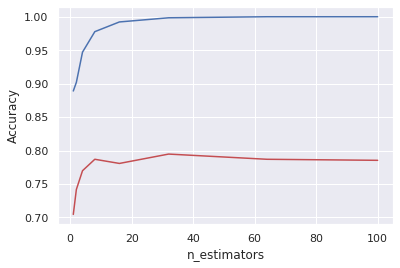

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


line1, = plt.plot(n_estimators, train_results, "b")
line2, = plt.plot(n_estimators, valid_results, "r")

plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.show()

По графику видно, что оптимальное значение кол-ва деревьев около 30. После него будет ухудшаться производительность, но точность не возрастает. 

Далее, посмотрим на влияние "глубины" деревьев на точность. Для этого будем изменять значения от 1 до 32 и по результатам также построим график. 

In [10]:
max_depth = range(1,33)

train_results = []
valid_results = []

for n in max_depth:
    model = RandomForestClassifier(random_state = 322, n_estimators=32, max_depth = n)
    model.fit(X_train,y_train)
    
    train_results.append(model.score(X_train,y_train))
    valid_results.append(model.score(X_val,y_val))
    

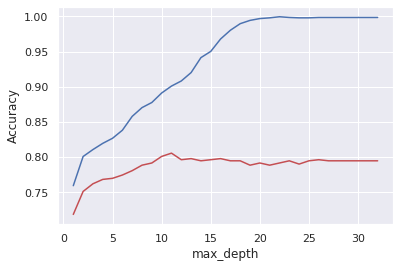

In [11]:
line1, = plt.plot(max_depth, train_results, "b")
line2, = plt.plot(max_depth, valid_results, "r")

plt.ylabel("Accuracy")
plt.xlabel("max_depth")
plt.show()

Самое высокое значение accuracy у нас при глубине около 10. Посмотрим, чему у нас равняется итоговое качество модели с параметрами:

* n_estimators = 30
* max_depth = 10

In [12]:
%%time
rnd_forest = RandomForestClassifier(random_state = 322, n_estimators=30, max_depth = 10)
rnd_forest.fit(X_train,y_train)
print(f"VAL accuracy = {rnd_forest.score(X_val,y_val)}")

VAL accuracy = 0.8055987558320373
CPU times: user 115 ms, sys: 48 µs, total: 115 ms
Wall time: 113 ms


##### Дополнительно. Улучшаем модель путём подбора лучших значений

Попробуем увеличить значение нашей точности путём одновременного изменения параметров и последующим выбором наилучшего значения. 

Для этого сделаем двойной цикл, в котором:
* значения max_depth будут в диапазоне от 7 до 15.
* кол-во деревьев будет в промежутке от 25 до 35.
* после обучения будем сохранять значения в переменной val_score, где:

```
[n_estimators, max_depth, validation accuracy score]
```

In [13]:
md = range(7,16)
n = range(25,35)
val_score = []

for n_e in n:
    for m in md:
        rnd_forest = RandomForestClassifier(n_estimators=n_e, random_state=322, max_depth=m)
        rnd_forest.fit(X_train, y_train)
        val_score.append([n_e,m,rnd_forest.score(X_val, y_val)])

In [14]:
max = [0,0,0]
for i in val_score:
    if i[2]>max[2]:
        max = i
max

[27, 10, 0.8087091757387247]

У нас получилось достичь 80.9% точности на валидационных значениях с количеством деревьев 27 и глубиной 10.
Посмотрим, что смогут показать другие модели.

### DecisionTreeClassifier

Импортируем эту модель из библиотеки. Наше древо находится в разделе *sklearn.tree*

In [15]:
from sklearn.tree import DecisionTreeClassifier

Посмотрим, сколько данная модель выдаст со стандартными значениями. 

In [16]:
dec_tree = DecisionTreeClassifier(random_state = 322)
dec_tree.fit(X_train,y_train)
print(dec_tree.score(X_val,y_val))

0.7200622083981337


На валидационной выборке у нас получилось всего 72 %. Данная модель проигрывает по качеству случайным деревьям, но выигрывает по скорости. Далее рассмотрим логистическую регрессию.

Посмотрим сколько такая модель может выдать при глубине = 5. 

In [17]:
%%time
dec_tree = DecisionTreeClassifier(random_state = 322, max_depth = 5)
dec_tree.fit(X_train,y_train)
print(dec_tree.score(X_val,y_val))

0.7838258164852255
CPU times: user 7.54 ms, sys: 12 µs, total: 7.55 ms
Wall time: 6.28 ms


У нас при изменении только 1 гиперпараметра удалось достичь 78%. 

### LogisticRegression

Импортируем модель из *sklearn.linear_model*. Обучим модель на нашей выборке и посмотрим, какую точность она выдаст при стандартных параметрах.

In [18]:
%%time
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state = 322)
log_reg.fit(X_train,y_train)
print(log_reg.score(X_val,y_val))

0.6858475894245724
CPU times: user 13 ms, sys: 0 ns, total: 13 ms
Wall time: 16 ms


Ошибка сообщает о том, что в новой версии Sklearn (0.22) гиперпараметр *solver* будет изменён на *lbfgs*. 

У нас получилось 72% на валидационной выборке. 

### Вывод

|Model|Default|Tune|
|-----|-------|----|
|Random Forest| 78% | ~81%|
|DecisionTreeClassifier |72% | 78% |
|Logistic Regression | 72% | | 

Для нас является ключевой метрикой 


По данной таблице можно увидеть, что модель случайных деревьев даже при стандартных значениях показывает более высокий результат на нашей валидационной выборке. При "тюнинге" гиперпараметров нам удалось достичь ~81% точности, однако стоит учитывать, что Random Forest Classifier медленее работает, чем DecisionTreeClassifier. Используем именно эту модель как итоговую. 

Проверим нашу модель на тестовой выборке.

## 4. Проверьте модель на тестовой выборке

Ранее нам удалось оптимальные значения гиперпараметров, при которых у нас получилась максимальная точность на валидационной выборке. 

Проверим нашу модель на тестовой выборке.

In [19]:
des_tree = DecisionTreeClassifier(random_state=322, max_depth=4)
des_tree.fit(X_train,y_train)
print(des_tree.score(X_test,y_test))

0.7729393468118196


У нас вышло 77%. Данная модель подходит под требуемые критери. 

## 5. (бонус) Проверьте модели на адекватность


Посмотрим на баланс классов в изначальной выборке. 

In [20]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Посчитаем процентное соотношение классов. 

In [21]:
smart_class_percent = (df['is_ultra'].value_counts()[0] * 100)/df['is_ultra'].count()
ultra_class_percent = 100 - smart_class_percent
print(f'Процент пользователей:\n\tSmart ~ {smart_class_percent}%\n\tUltra ~ {ultra_class_percent}%')

Процент пользователей:
	Smart ~ 69.3528313627878%
	Ultra ~ 30.647168637212204%


Согласно данному распределению, адекватная модель должна выдать качество более 69%. 

Ранее, мы проводили исследование работы разных моделей, в которых было видно, что минимальная точность более 100%. 

|Model|Default|Tune|
|-----|-------|----|
|Random Forest| 78% | ~81%|
|DecisionTreeClassifier |72% | 78% |
|Logistic Regression | 72% | | 

Посмотрим, какое у нас распределение классов на обучающей выборке. 

In [22]:
(y_train.value_counts()[0] * 100)/y_train.count()

70.17634854771784

Мы получаем соотношение классов 70:30 и наши модели выдали минимальную точность в 72%, что подтверждает их адекватность. 

## Общий вывод

В работе была построена рекомендательная модель тарифных планов. Для построения использовались следующие признаки:

* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,

На выходе из модели мы получаем рекомендуемый нам тариф, где 0 - "Смарт", а 1 - "Ультра".

Были проанализированы три модели:

* Random Forest Classifier
* Decision Tree Сlassifier
* Logistic Regression

Метрикой корректности работы модели послужила 

При использование Random Forest нам изначально удалось достичь требуемой точности (78%), но при дальшейшем изменении гиперпараметров точность повысилась до 81%.

При изменении гиперпараметра глубины модель DecisionTreeClassifier выдала 78% точности, что уже удовлетворяет нашим требованиям. 

Для дальнейшей работы можно использовать обе эти модели, однако надо учитывать, что RandomForestClassifier работает медленнее, чем Decision Tree. 
